In [1]:
import numpy
from matplotlib.pyplot import *
import pandas as pd
from math import pi


i_rho  = 0
i_rhou = 1


#------------------------------------------#

def euler_flux(grid,pars,cons_rec):

    f = numpy.zeros((2,grid.Nx+1))

    f[i_rho,:]  = cons_rec[i_rhou,:]
    f[i_rhou,:] = cons_rec[i_rhou,:]**2/cons_rec[i_rho,:] \
    + cons_rec[i_rho,:]*pars.cs**2

    return f

#------------------------------------------#

class Pars:

    def __init__(self):

        self.Nx     = None
        self.x1     = None
        self.x2     = None
        self.cs     = None
        self.cfl    = None
        self.tmax   = None

#------------------------------------------#

class Grid:

    def __init__(self,pars):

        self.Nx      = pars.Nx
        self.dx      = (pars.x2-pars.x1)/self.Nx
        self.xc      = numpy.linspace(pars.x1+self.dx/2.,pars.x2-self.dx/2.,self.Nx)
        self.cons    = numpy.zeros((2,self.Nx+2))
        self.time    = 0.
        self.dt      = None
        self.i_model = 0

    def get_dt(self,pars):
        u  = self.cons[1,1:-1]/self.cons[0,1:-1]
        cs = pars.cs
        self.dt = pars.cfl*self.dx/numpy.max(numpy.abs(u)+cs)

    def apply_periodic_bcs(self,pars):
        self.cons[:,0]  = self.cons[:,-2]
        self.cons[:,-1] = self.cons[:,1]

    def reconstruct(self,pars):
        return self.cons[:,:-1], self.cons[:,1:] #left-right states

    def rk1_update(self,pars,R):
        self.cons[:,1:-1] -= R[:,:]*self.dt


#------------------------------------------#


def hll_riemann(grid,pars,L,R):

        fL    = euler_flux(grid,pars,L)
        fR    = euler_flux(grid,pars,R)
        f     = numpy.zeros_like(fL)
        uL    = L[i_rhou,:]/L[i_rho,:]
        uR    = R[i_rhou,:]/R[i_rho,:]
        c     = pars.cs
        SL    = numpy.minimum(uL,uR) - c
        SR    = numpy.maximum(uL,uR) + c

        kk_L    = numpy.where(SL>=0.)
        kk_star = numpy.where((SL<0.) & (SR>0.))
        kk_R    = numpy.where(SR<=0.)

        f[:,kk_L]    = fL[:,kk_L]
        f[:,kk_star] = (SR[kk_star]*fL[:,kk_star] - SL[kk_star]*fR[:,kk_star] +\
         SL[kk_star]*SR[kk_star]*(R[:,kk_star]-L[:,kk_star]))/(SR[kk_star]-SL[kk_star])
        f[:,kk_R]    = fR[:,kk_R]

        return f


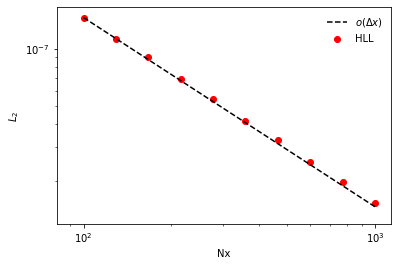

In [2]:
x_Nx = []
y_L2 = []

for Nx in numpy.logspace(2,3,10):

    p = Pars()

    p.Nx     =  int(Nx)
    p.x1     =  0.
    p.x2     =  1.
    p.cs     =  1.
    p.cfl    =  0.4
    p.tmax   =  1.

    g = Grid(p)

    A   = 1.e-6
    g.cons[i_rho,1:-1]  = 1.0 + A*numpy.sin(2*pi*g.xc)
    g.cons[i_rhou,1:-1] = A*(-1.)*numpy.sin(2*pi*g.xc)

    cons_0 = numpy.copy(g.cons)

    while(g.time<p.tmax):

        g.get_dt(p)
        g.apply_periodic_bcs(p)
        consL,consR=g.reconstruct(p)
        flux = hll_riemann(g,p,consL,consR)
        R = (flux[:,1:]-flux[:,:-1])/g.dx
        g.rk1_update(p,R)
        g.time += g.dt
        g.i_model += 1


    err = numpy.sum(numpy.abs(cons_0[:,1:-1]-g.cons[:,1:-1]))/g.Nx
    L2  = (numpy.sum(err**2))**0.5

    x_Nx.append(Nx)
    y_L2.append(L2)


Nx  = numpy.array(x_Nx)
L2  = numpy.array(y_L2)
lin = L2[0]*(Nx[0]/Nx)

plot(Nx,lin,label=r'$o(\Delta x)$',color='black',ls='--')
scatter(Nx,L2,label='HLL',color='red')
xlabel('Nx')
ylabel(r'$L_2$')
yscale('log')
xscale('log')
legend(frameon=False)
show()
